Прежде чем запускать следующее, нужно пройти VK-авторизацию!

In [9]:
import numpy as np
import pandas as pd
import matplotlib
from collections import defaultdict
from matplotlib import pyplot as plt
from urllib import urlencode

import urllib2
import time
import json
import operator
import urllib2 

In [10]:
file = open('datasets/token', 'r')
accessToken = file.read()

# Достаем участников групп

In [15]:

users = []

for i in range(0, 2):
    params = {"group_id": "spbgu_ru", 
              "count": 1000, 
              "offset": 1000 * i,
              "fields": "sex,education,universities,schools",
              "access_token": accessToken}
    params = urlencode(params)

    url = "https://api.vk.com/method/groups.getMembers?" + params
    data = json.load(urllib2.urlopen(url))
    data_users = data['response']['users']
    
    print("extracted %d users" % len(data_users))
    users.extend(data_users)
    time.sleep(0.5)
    
print("sum: %d" % len(users))

f = open('datasets/spbuPeople/users.json','w')
f.write(json.dumps(users))
f.close()

 extracted 1000 users
extracted 1000 users
sum: 2000


# Университеты полицейских

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


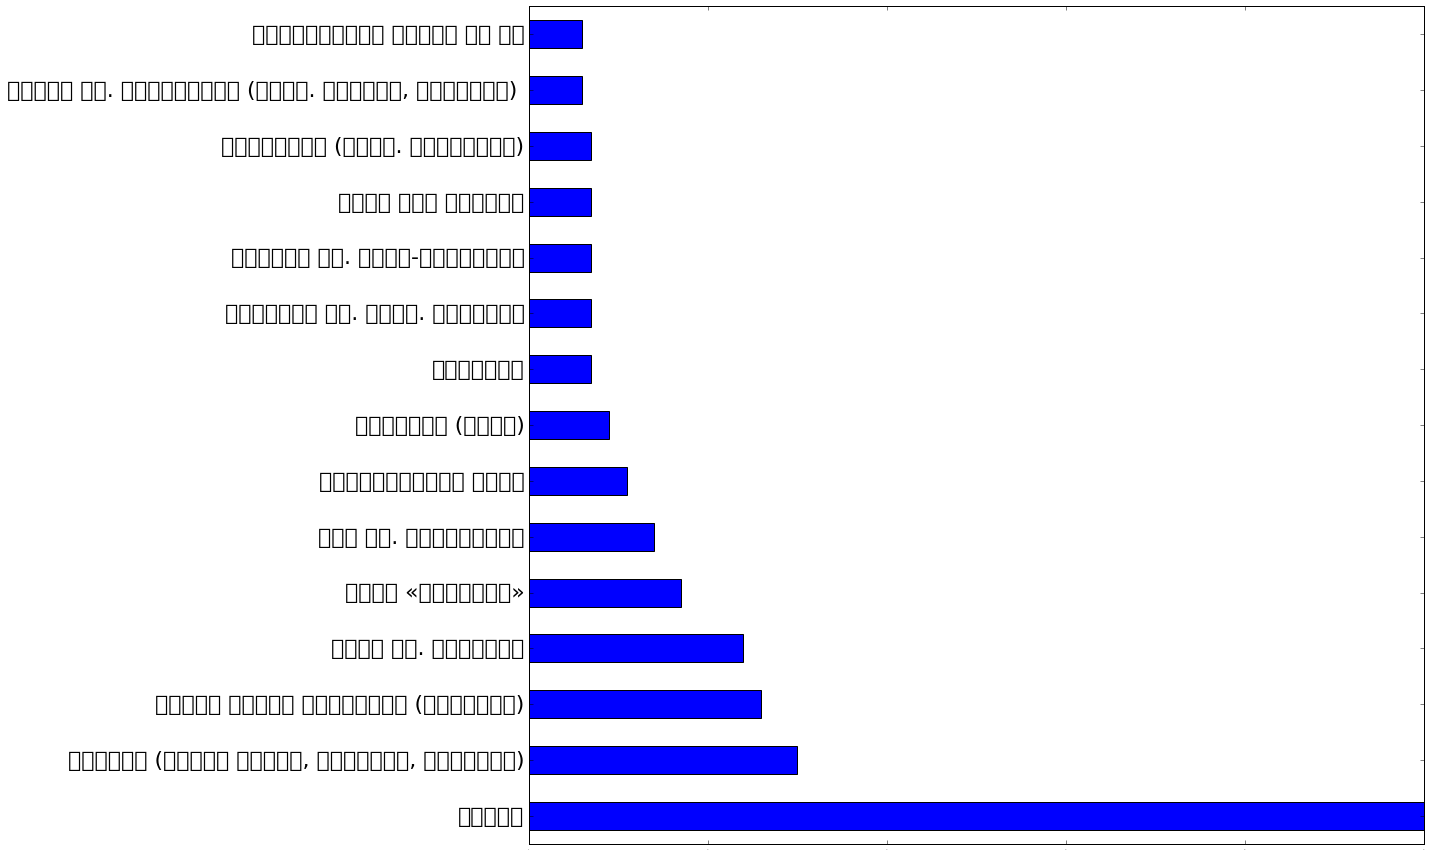

In [11]:
%matplotlib inline

with open('datasets/randomPeople/users.json') as data_file:    
    users = json.load(data_file)

df = pd.DataFrame(users)
df = df.groupby('university_name').size()

df.sort(['university_name'], ascending=False)
df = df.drop(df.index[[0]])
plt.figure(figsize=(15, 20))

matplotlib.rc('xtick', labelsize=0)
matplotlib.rc('ytick', labelsize=22)

p = df[:15].plot(kind='barh')
p.set_xlabel("")
p.set_ylabel("")
p.get_figure().set_size_inches(20, 12)
p.get_figure().tight_layout()
p.get_figure().savefig('images/universities_non_police_all.png', dpi=100)

# Пол полицейских

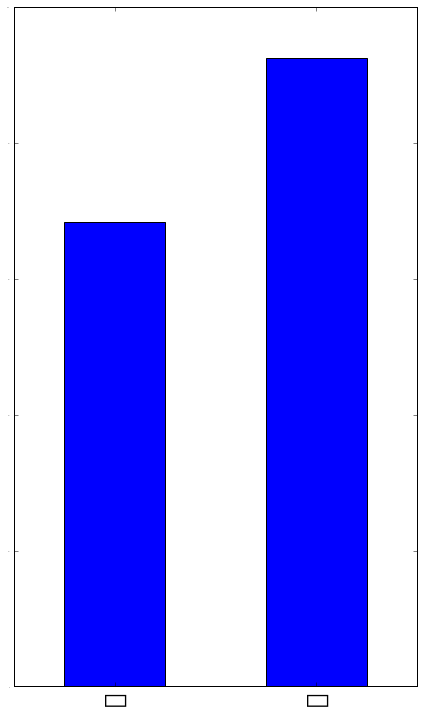

In [12]:
%matplotlib inline

with open('datasets/policeGroups/users.json') as data_file:    
    users = json.load(data_file)

def update_sex(user):
    user['sex_name'] = {
        0: 'N/A',
        1: u'Ж',
        2: u'М',
    }[user['sex']]
    return user

users = map(update_sex, users)
users = filter(lambda x: x['sex'] != 0, users)
    
df = pd.DataFrame(users)
df = df.groupby('sex_name').size()

matplotlib.rc('xtick', labelsize=24)
matplotlib.rc('ytick', labelsize=0)

p = df.plot(kind='bar')
p.set_xlabel("")
p.get_figure().set_size_inches(6, 10)
p.get_figure().tight_layout()
p.get_figure().savefig('images/sex_police.png', dpi=100)

# Группы полицейских
Загружаем и кладем в файл

In [17]:
with open('datasets/spbuPeople/users.json') as data_file:    
    users = json.load(data_file)

groups = {}

print("processing %d users" % len(users))
for i in range(0, len(users)):
    params = {"user_id": users[i]['uid'], 
              "extended": 0, 
              "access_token": accessToken}
    params = urlencode(params)

    url = "https://api.vk.com/method/groups.get?" + params
    data = json.load(urllib2.urlopen(url))
    
    if data.get('response', ''):
        user_groups = data['response']
        for user_group in user_groups:
            groups[user_group] = groups.get(user_group, 0) + 1

        print "%d" % (i + 1),
    time.sleep(0.5)
    
f = open('datasets/policeGroups/groups_ids.json','w')
f.write(json.dumps(groups))
f.close()

 processing 2000 users
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 161 162 163 164 165 166 167 168 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 2

### Достанем названия каждой из групп из API и сохраняем все в файл

In [278]:
with open('datasets/policeGroups/groups_ids.json') as data_file:    
    groups = json.load(data_file)
    
sorted_groups = sorted(groups.items(), key=operator.itemgetter(1))
sorted_groups.reverse()

# ids of first 100 groups as string
group_ids = ",".join(map(lambda x: x[0], sorted_groups[:100]))
params = {"group_ids": group_ids}
params = urlencode(params)
url = "https://api.vk.com/method/groups.getById?" + params
data = json.load(urllib2.urlopen(url))

# function to "attach" people count to groups
def add_people_count(group_info):
    group_info['people_count'] = groups.get(str(group_info['gid']), 0)
    return group_info

if data.get('response', ''):
    groups_info = data['response']
    groups_info = map(add_people_count, groups_info)
    
    f = open('datasets/policeGroups/groups.json','w')
    f.write(json.dumps(groups_info))
    f.close()

### Загрузка полного датасета из файла и построение графика

In [279]:
with open('datasets/policeGroups/groups.json') as data_file:    
    groups_info = json.load(data_file)

IOError: [Errno 2] No such file or directory: 'datasets/policeGroups/groups.json'

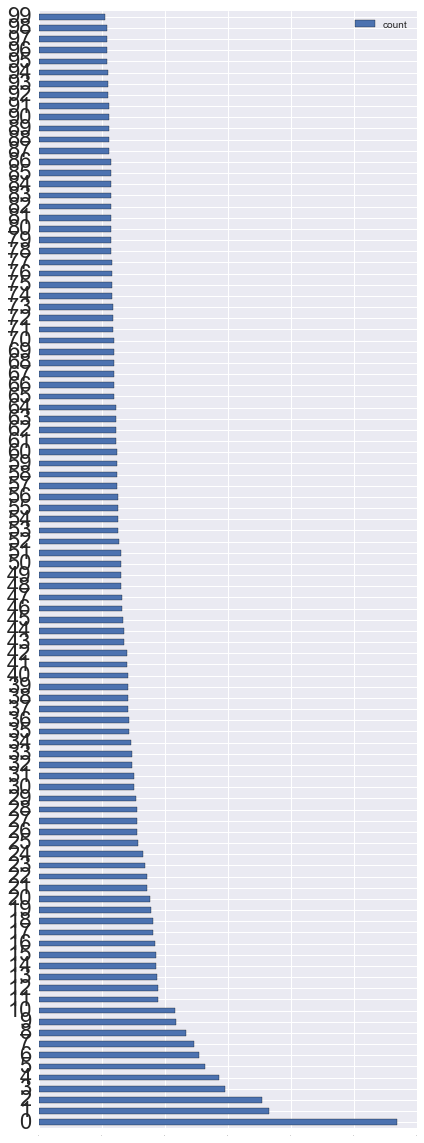

In [403]:
%matplotlib inline

def process_group_info(i):
    return {"name": i.get('name', ''),
            "count": i.get('people_count', 0)}

df = pd.DataFrame(map(process_group_info, groups_info))

p = df.plot(kind='barh')
p.get_figure().set_size_inches(6, 16)
p.get_figure().tight_layout()
p.get_figure().savefig('images/interests_police.png', dpi=100)